# MALIS Lab Session 1 - Fall 2019
October 15 2019
___
**Group 25**

BUSSOTTI Jean Flavien

GUYARD Martin
___

The aim of this lab is to practice with linear models for both regression and classification via simple experiments. 

#### Learning goals
After this lab, you should be able to:
1. Interpret the coefficent estimates produced by a linear model
2. Be familiar with the use of polynomial and categorical features
3. Be familiar with the building blocks of a pipeline to make building, fitting, and tracking models easier
3. Be able to make an informed choice of model based on the data at hand
4. Understand the key differences between nearest neighbor and linear models

#### Instructions:
Experiments should be made by groups of two students. Each group should produce a Jupyter Notebook with all their results and comments. 

Submit your complete notebook as an archive (tar -cf groupXnotebook.tar lab1/). **Deadline for submitting your notebook:** 25 October 2018 23:59:59 (CET) 

## Part 1: Linear Regression
In this part, we will be working with a dataset scraped by <a href="https://www.kaggle.com/mauryashubham/linear-regression-to-predict-market-value/data">Shubham Maurya</a>, which collects facts about players in the English Premier League as of 2017. His original goal was to establish if there was a relationship between a player's popularity and his market value, as estimated by transfermrkt.com.

**Your goal is to fit a model able to predict a player's market value.**

The dataset contains the following information:

| **Field**   |     **Description**      |  
|-------------|-------------|
| name   |  Name of the player | 
| club   |  Club of the player |
| age    | Age of the player |
|position| The usual position on the pitch|
|position_cat| 1 for attackers, 2 for midfielders, 3 for defenders, 4 for goalkeepers|
|market_value| As on transfermrkt.com on July 20th, 2017|
|page_views| Average daily Wikipedia page views from September 1, 2016 to May 1, 2017|
|fpl_value| Value in Fantasy Premier League as on July 20th, 2017|
|fpl_sel| % of FPL players who have selected that player in their team|
|fpl_points| FPL points accumulated over the previous season|
|region| 1 for England, 2 for EU, 3 for Americas, 4 for Rest of World|
|nationality| Player's nationality|
|new_foreign| Whether a new signing from a different league, for 2017/18 (till 20th July)|
|age_cat| a categorical version of the Age feature|
|club_id| a numerical version of the Club feature|
|big_club| Whether one of the Top 6 clubs|
|new_signing| Whether a new signing for 2017/18 (till 20th July)|

**Step 1:** The very first step is to have a deeper look into the data:

In [1]:
import pandas as pd
import numpy as np
import utils
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

np.random.seed(0)

In [2]:
league_df = pd.read_csv("data/football_data.csv")

print(league_df.dtypes)     # Prints out the data types associated to each of the fields in the table
league_df.head()            # df.head(N) displays the top N entries of a dataframe. If no arguments shows 5 by default.

name             object
club             object
age               int64
position         object
position_cat      int64
market_value    float64
page_views        int64
fpl_value       float64
fpl_sel          object
fpl_points        int64
region          float64
nationality      object
new_foreign       int64
age_cat           int64
club_id           int64
big_club          int64
new_signing       int64
dtype: object


,name,club,age,position,position_cat,market_value,page_views,fpl_value,fpl_sel,fpl_points,region,nationality,new_foreign,age_cat,club_id,big_club,new_signing
0,Alexis Sanchez,Arsenal,28,LW,1,65.0,4329,12.0,17.10%,264,3.0,Chile,0,4,1,1,0
1,Mesut Ozil,Arsenal,28,AM,1,50.0,4395,9.5,5.60%,167,2.0,Germany,0,4,1,1,0
2,Petr Cech,Arsenal,35,GK,4,7.0,1529,5.5,5.90%,134,2.0,Czech Republic,0,6,1,1,0
3,Theo Walcott,Arsenal,28,RW,1,20.0,2393,7.5,1.50%,122,1.0,England,0,4,1,1,0
4,Laurent Koscielny,Arsenal,31,CB,3,22.0,912,6.0,0.70%,121,2.0,France,0,4,1,1,0


In [3]:
league_df.describe() #Generates descriptive statistics that summarize the central tendency, dispersion and shape of a dataset’s distribution (numeric)

,age,position_cat,market_value,page_views,fpl_value,fpl_points,region,new_foreign,age_cat,club_id,big_club,new_signing
count,461.000000,461.000000,461.000000,461.000000,461.000000,461.000000,460.000000,461.000000,461.000000,461.000000,461.000000,461.000000
mean,26.804772,2.180043,11.012039,763.776573,5.447939,57.314534,1.993478,0.034707,3.206074,10.334056,0.303688,0.145336
std,3.961892,1.000061,12.257403,931.805757,1.346695,53.113811,0.957689,0.183236,1.279795,5.726475,0.460349,0.352822
min,17.000000,1.000000,0.050000,3.000000,4.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,24.000000,1.000000,3.000000,220.000000,4.500000,5.000000,1.000000,0.000000,2.000000,6.000000,0.000000,0.000000
50%,27.000000,2.000000,7.000000,460.000000,5.000000,51.000000,2.000000,0.000000,3.000000,10.000000,0.000000,0.000000
75%,30.000000,3.000000,15.000000,896.000000,5.500000,94.000000,2.000000,0.000000,4.000000,15.000000,1.000000,0.000000
max,38.000000,4.000000,75.000000,7664.000000,12.500000,264.000000,4.000000,1.000000,6.000000,20.000000,1.000000,1.000000


**Step 2 - Prepare the data:** As we did with the Men's Olympic 100m data, we will split our data into two sets: One data set for training and another one that we will use at the end to test our model. 

In [4]:
# Split data in two. For the purpose of this lab, you do not need to worry about how data is split. This is done for you.
train = pd.read_csv('data/train_football_data.csv')
test = pd.read_csv('data/test_football_data.csv')

# #We create array variables to store our target variable, which is the market value of a player
y_train = train['market_value']
y_test = test['market_value']

The dataset contains a lot of features that can be used to build the model. We will start by using <code>age, fpl_value, big_club</code> and <code>page_views</code>. 

\begin{equation}
 \hat{y} = W_0 + W_1x_{age} + W_2x_{fplavalue} + W_3x_{bigclub} + W_4x_{pageviews}
\end{equation}

The function below prepares the data by selecting these features and then adding the dummy variable $x_0 = 1$.

In [5]:
def prepare_X(ds):
    '''
    Prepares training data by selecting the features to use and the adding the dummy variable x[0] = 1
    '''
    X_cols = ds[['age', 'fpl_value', 'big_club']].copy()
    X_cols['sqrt_page_views'] = np.sqrt(ds[['page_views']])
    X = X_cols.values
    X = X.reshape(len(X_cols),-1)
    
    #We add the dummy x_0
    poly = PolynomialFeatures(1)  
    X = poly.fit_transform(X)

    return X

In [6]:
#Call prepare_X to prepare training data. We do the same for test data, although this will only be used later on.
X = prepare_X(train)
X_test = prepare_X(test)

**Step 3 - Training:** The line of code below calls the function fit_model which has been already implemented for you (see utils.py but, do not edit it). By running it you obtain the estimated parameters $\hat{\mathbf{W}}$ of the linear regressor model.

In [7]:
W = utils.fit_model(X,y_train.values)
print(W)

[-17.50064011  -0.16123258   4.63871994   5.52418665   0.24716004]


**Step 4 - Predict and evaluate:** The function <code>run</code> below collects all the necessary steps to predict and then evaluate a particular model. As inputs it receives the model parameters (i.e. $\mathbf{W}$), an input dataset <code>X_test</code> and the corresponding targets <code>y_test</code>. Internally, it calls two functions:

1. <code>predict</code> which estimates $\hat{y}=\mathbf{X\hat{W}}$ given the model parameters and an input sample and then returns the predicted targets.
2. <code>MSE</code> which computes the mean squared error (and then returns it):
\begin{equation}
MSE = \dfrac{1}{N}\sum_{i=1}^{N}(y_i -\hat{y}_i)^2
\end{equation}
where $i$ denotes the index of the $i^{th}$ sample and $N$ the total number of samples.

<div class="alert alert-info">

**Exercise 1:** Implement <code>predict(W,X)</code> and <code>MSE(y, y_hat)</code>

</div>

In [8]:
def run(W, X_test, y_test):
    '''
    Collects the necessary steps to predict and then evaluate a particular model. 
    As inputs it receives the model parameters an input dataset X_test and the corresponding targets y_test
    It returs the MSE.
    '''
    y_hat_test = predict(W,X_test)
    mse = MSE(y_test, y_hat_test)
    
    return mse

def predict(W, X):
    # Predict y_hat = XW_hat
    res = np.dot(X, W)
    
    return res

def MSE(y, y_hat):
    # Compute mean squared error
    assert len(y) == len(y_hat)
    mse = 0
    for i in range(len(y)):
        mse += np.power(y[i]-y_hat[i], 2)
    mse = mse/len(y)
    
    return mse
        
    

Now, you can have a look at the parameters of your model and also at how well it fits the training data according to the MSE:

In [9]:
mse_train = run(W,X,y_train)
mse_test  = run(W, X_test, y_test)

print('*******************************************************************************************')
print('[W_0,W] : [', W[0],',', W[1:], ']' )
print('TRAINING MSE : ', mse_train)
print('TEST MSE     : ', mse_test)
print('*******************************************************************************************')

*******************************************************************************************
[W_0,W] : [ -17.500640108847183 , [-0.16123258  4.63871994  5.52418665  0.24716004] ]
TRAINING MSE :  43.35479200809761
TEST MSE     :  32.689095259412646
*******************************************************************************************


The estimated weights W (excluding $W_0$) are associated to 'age', 'fpl_value', 'big_club' and 'log_page_views'. 

<div class="alert alert-info">

**Question 1:** How do you interpret the valued of each of these parameters? Based on this information, what can you say about the effect in a player's market value of his:
    1. age?
    2. number of page views?
    3. fpl value

Which of this feature seems to have the largest effect on a player's value?
</div>

**Your answer here:** 
___
Coefficient for $fpl\_value$ and $big\_club$ are a lot higher than coefficients for $age$ and $log\_page\_views$. This means player's market value is more sensible to $fpl\_value$ and $big\_club$ values. Slight change on age and $log\_page\_views$ won't affect much the player's value otherwise slight changes in $fpl\_value$ and $big\_club$ features can change the player's market value a lot.
___


#### Including polynomial features
A *scatter matrix* a pair-wise scatter plot of several variables presented in a matrix format. It can be used to determine whether the variables are correlated and whether the correlation is positive or negative.

From the scatter matrix below we can explore the relationship that each "potential" input variable has with the target variable, the market value. 

When looking at the correlation between age and market value (first column, third row), it does not seem to be linear. 

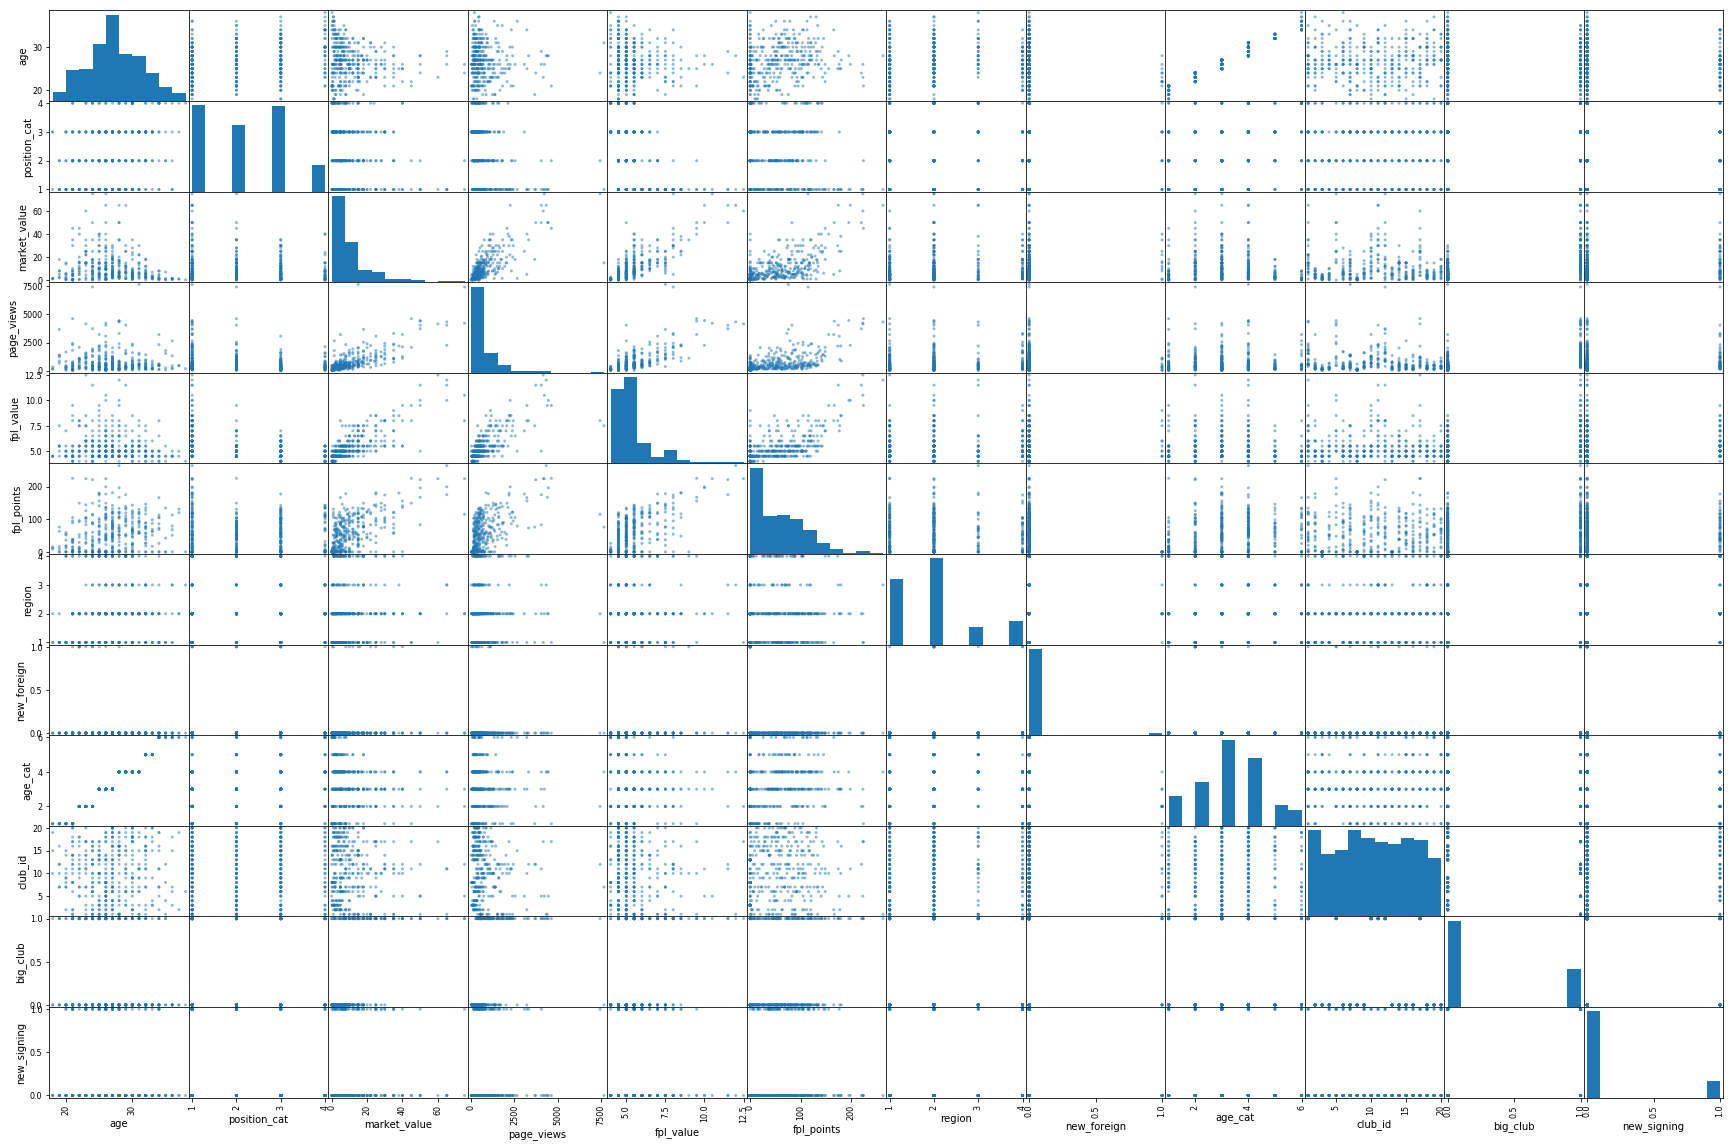

In [10]:
from pandas.plotting import scatter_matrix
scatter_matrix(train, figsize=(30,20));

In more detail:

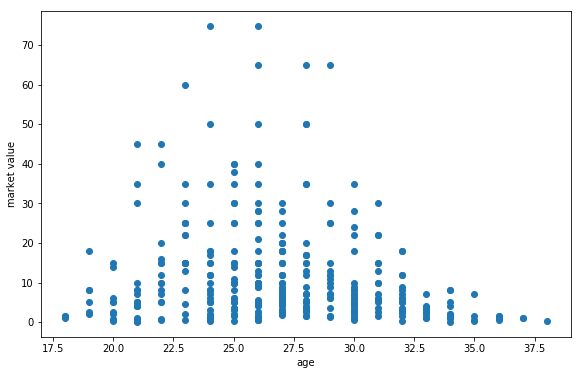

In [11]:
plt.rcParams['figure.figsize'] = [9.5, 6]
plt.scatter(X[:,1], y_train.values)
plt.xlabel('age')
plt.ylabel('market value')
plt.show()

Let us explore considering a more complex effect of the age by including a quadratic term: 

\begin{equation}
 \hat{y} = w_0 + w_1*x_{age} + w_2x_{fplavalue} + w_3*x_{bigclub} + w_4*x_{pageviews} + w_5*x_{age}^2
\end{equation}

The function below prepares the datato fit to this new model.

<div class="alert alert-info">

**Exercise 2:** Complete the code below to include the quadratic term regarding the age.  

</div>

In [12]:
def prepare_X_with_age(ds):
    '''
    Linear with age**2
    '''
    X_cols = ds[['age', 'fpl_value', 'big_club', 'page_views']].copy()
    X_cols['q_age'] = np.power(ds[['age']], 2)
      
    poly = PolynomialFeatures(1)  
    X = poly.fit_transform(X_cols)
    
    return X


In [37]:
X_sqr_train = prepare_X_with_age(train)
X_sqr_test  = prepare_X_with_age(test)

W_sqr = utils.fit_model(X_sqr, y_train)

mse_sqr_train = run(W_sqr, X_sqr_train, y_train)
mse_sqr_test  = run(W_sqr, X_sqr_test, y_test)

print('********************* Results with age^2 ***************************************************')
print('[W_0, W] : [', W_sqr[0],',', W_sqr[1:], ']' )
print('TRAINING MSE : ', mse_sqr_train)
print('TEST MSE     : ', mse_sqr_test)
print('********************************************************************************************')

NameError: name 'prepare_X_with_age' is not defined

<div class="alert alert-info">

**Question 2:** Based on your results, what can you say about adding this term $age^2$ to your model?

</div>

**Your answer here:** 
___
The MSE is better. Adding a polynomial feature ($age^2$), decreased the MSE from 43 to 38 on training set, and from 32 to 26 on test set. We also found out that $log(page\_views)$ gave poorer MSE than $page\_views$ alone. At first sight, adding $age^2$ is better because the MSE is lower, however it happens quite often that, adding polynomial feature create a more "complex" model more prone to overfitting. One should always be carefull to this when adding polynomial features. 
___

#### Including categorical features
It is well known that the position where a football player plays has an impact in his market value. Midfielders and stikers tend to be more expensive. *Your goal now is to include this information in the model.*  

As seen from the description, the player position is encoded as a numeric variable (1, 2, 3, 4). However, they represent categories and not values on their own. Categorical variables are commonly encoded under a scheme denoted 1-of-K encoding. This allows to convert a variable representing K different categories into K different binary values. Example: 

| **attacker**   |     **midfielder** | **defender** | **goalkeeper**      |  
|-------------|-------------|-------------|-------------|
| 1   |  0 | 0 | 0 |
| 0   |  1 | 0 | 0 |
| 0   |  0 | 1 | 0 |
| 0   |  0 | 0 | 1 |


<div class="alert alert-info">

**Exercise 3:** Implement 1-of-K encoding and complete the code below so that your model includes information about a player's position
\begin{equation}
 \hat{y} = w_0 + w_1x_{age} + w_2x_{fplavalue} + w_3x_{bigclub} + w_4x_{pageviews} + w_5x_{age}^2 + w_6x_{attaker} + w_7x_{midfielder} + w_8x_{defender} +w_9x_{goalkeeper}
\end{equation}    

</div>

In [ ]:
def prepare_X_with_position(ds):
    '''
    With position_cat as 1-K
    '''
    X_cols = ds[['age', 'fpl_value', 'big_club', 'page_views']].copy()
    X_cols['q_age'] = np.power(ds[['age']], 2)
    
    # 1-K position
    X_cols = pd.concat([X_cols, pd.get_dummies(ds['position_cat'])], axis=1)
    
    poly = PolynomialFeatures(1)  
    X = poly.fit_transform(X_cols)

    return X

In [ ]:
X_pos_train = prepare_X_with_position(train)
X_pos_test = prepare_X_with_position(test)

W_pos = utils.fit_model(X_pos_train, y_train)

mse_pos_train = run(W_pos, X_pos_train, y_train)
mse_pos_test = run(W_pos, X_pos_test, y_test)

print('***************************** Results with player\'s position *******************************************')
print('[W_0,W] : [', W_pos[0],',', W_pos[1:], ']' )
print('TRAINING MSE : ', mse_pos_train)
print('TEST MSE     : ', mse_pos_test)
print('*******************************************************************************************')

In [ ]:
print('***************************** Summary: Training error *******************************************')
print('MSE model 1: ', mse_train)
print('MSE model 2: ', mse_sqr_train)
print('MSE model 3: ', mse_pos_train)

In [ ]:
print('***************************** Summary: Test error *******************************************')
print('MSE model 1: ', run(W, X_test, y_test))
print('MSE model 2: ', run(W_sqr, X_sqr_test, y_test))
print('MSE model 3: ', run(W_pos, X_pos_test, y_test))

<div class="alert alert-info">

**Question 3:** Based on your results, what can you say about adding the player's position to your model?

</div>

**Your answer here:** 
___
Adding the player's position reduced MSE on training set but increased the MSE on test set. This might be an indicator that our model is overfitting our training data.
___

<div class="alert alert-info">

**Exercise 4:** To deal with the apparent non-linear relationship between age and market value, 
<a href="https://www.kaggle.com/mauryashubham/linear-regression-to-predict-market-value/data">Shubham Maurya</a> suggests to use categorical features for the age. Using your implementation of the 1-of-K encoding, include the age categorical features into the model. 

It is up to you to decide if you will keep or not currently used $x_{age}$ and $x_{age}^2$. Whichever your choice is, <u>justify clearly your answer</u>. 

</div>

In [ ]:
def prepare_X_with_position_and_age(ds):
    X_cols = ds[['age', 'fpl_value', 'big_club', 'page_views']].copy()
    X_cols['age_squared'] = np.power(X_cols['age'], 2)
    
    # 1-K position
    X_cols = pd.concat([X_cols, pd.get_dummies(ds['position_cat'])], axis=1)
    
    # 1-K age
    X_cols = pd.concat([X_cols,pd.get_dummies(ds['age_cat'], prefix='age_cat')], axis=1)
  
    poly = PolynomialFeatures(1)  
    X = poly.fit_transform(X_cols)
    
    return X

# Your answer here: 
# After evaluating MSE (train and test) we found out that keeping age and age^2 gave better score. 

In [ ]:
X_pa_train = prepare_X_with_position_and_age(train)
X_pa_test = prepare_X_with_position_and_age(test)

W_pa = utils.fit_model(X_pa_train, y_train)

mse_pa_train = run(W_pa, X_pa_train, y_train)
mse_pa_test = run(W_pa, X_pa_test, y_test)

print('*************** Results with player\'s position and age cat features***********************')
print('[W_0,W] : [', W_pa[0],',', W_pa[1:], ']' )
print('TRAINING MSE : ', mse_pa_train)
print('TEST MSE     : ', mse_pa_test)
print('*******************************************************************************************')

**In summary:** Let's summarize all the results obtained so far.

In [ ]:
print('***************************** Summary: Training error *******************************************')
print('MSE model 1: ', mse_train)
print('MSE model 2: ', mse_sqr_train)
print('MSE model 3: ', mse_pos_train)
print('MSE model 4: ', mse_pa_train)

<div class="alert alert-info">

**Question 4:** Based on these results, which model would you choose to predict a player's market value? Justify your answer.

</div>

**Your answer here:**
___
According to the MSE score on training set we would rather move with the last model because it provided the lowest MSE on training data.
___

**Step 4 - Prediction:** Now, let use the models to predict the market value of the players in the test data:

In [ ]:
print('***************************** Summary: Test error *******************************************')
print('MSE model 1: ', run(W,X_test, y_test))
print('MSE model 2: ', run(W_sqr,X_sqr_test, y_test))
print('MSE model 3: ', run(W_pos,X_pos_test, y_test))
print('MSE model 4: ', run(W_pa,X_pa_test, y_test))

<div class="alert alert-info">

**Question 5:** How did your model do? Was it the best performing? Based on your intuition (as this topic has not been yet covered), try to explain the obtained performance (i.e. why some models do better than others)? 

</div>

**Your answer here:** 
___
On unseen test data the best score is achieved by model 2, although on training data the best one is model 4. We are guessing, here, an overfitting issue. Model 4 is too 'complex' and almost memorize the training set without regularization, causing great MSE score on training data and poorer MSE score on test data.

In this situation we would rather move with model 2.
___

# Part 2: Linear Models for Classification


In this part, we will be working with the <a href="https://archive.ics.uci.edu/ml/datasets/heart+Disease">Heart Disease dataset</a>, from the <a href="https://archive.ics.uci.edu/ml/index.php">UCI Machine Learning Repository</a>. 

This database contains 76 attributes, but all published experiments refer to using a subset of 14 of them. In particular, the Cleveland database that we will use is the only one that has been used by ML researchers to this date. The "diagnosis" field refers to the presence of heart disease in the patient. It is integer valued from 0 (no presence) to 4. Additionally, there is a condition field that labels subjects as healthy (H, which is equivalent to condition 0) or with a diagnosed disease (D, which gathers any subject with condition 1-4). 

Experiments with the Cleveland database have concentrated on simply attempting to distinguish presence (values 1,2,3,4) from absence (value 0).

**The goal of this section is to build two classifiers: ona that can discriminate healthy from diseased subjects and a second one that can precisely identify the diagnosis of a subject.**

The dataset contains the following information:

| **Field**   |     **Description**      |  
|-------------|-------------|
| age         |  age in years |
| sex         |  (1 = male; 0 = female) |
|cp           |chest pain type |
|trestbps     |resting blood pressure (in mm Hg on admission to the hospital)|
|cholserum  |  cholestoral in mg/dl|
|fbs        |(fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)|
|restecg | resting electrocardiographic results|
|thalach |maximum heart rate achieved|
|exang | exercise induced angina (1 = yes; 0 = no)|
|oldpeak | ST depression induced by exercise relative to rest |
|slope |the slope of the peak exercise ST segment |
|ca | number of major vessels (0-3) colored by flourosopy |
|thal | 3 = normal; 6 = fixed defect; 7 = reversable defect|
| diagnosis | 0= normal, 1,2,3,4 disease conditions|
| condition | H=Healthy D=Diseased |

**Step 1:** As usual, we start by inspecting the dataset:

In [2]:
heart_df_full = pd.read_csv("data/processed.cleveland.data")

#The dataset contains some missing values. We are filtering them out here
heart_df = []
heart_df = heart_df_full[~(heart_df_full == '?').any(1)]

In [20]:
heart_df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,diagnosis,condition
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,H
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,D
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,D
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,H
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,H


In [21]:
heart_df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,diagnosis
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,54.542088,0.676768,3.158249,131.693603,247.350168,0.144781,0.996633,149.599327,0.326599,1.055556,1.602694,0.946128
std,9.049736,0.468500,0.964859,17.762806,51.997583,0.352474,0.994914,22.941562,0.469761,1.166123,0.618187,1.234551
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,1.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,243.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,276.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,4.000000


**Step 2 - Prepare the data:** First, we will split the data into a training and a testing dataset. For this lab, the data has already been split for you:

In [3]:
train = pd.read_csv('data/train_heart.csv')
test = pd.read_csv('data/test_heart.csv')

x_train = train.drop(['condition','diagnosis'], axis=1)
y_train = train['condition']

x_test = test.drop(['condition','diagnosis'], axis=1)
y_test = test['condition']

x_train.head()

,Unnamed: 0,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,137,62.0,1.0,2.0,120.0,281.0,0.0,2.0,103.0,0.0,1.4,2.0,1.0,7.0
1,178,43.0,1.0,3.0,130.0,315.0,0.0,0.0,162.0,0.0,1.9,1.0,1.0,3.0
2,111,56.0,1.0,4.0,125.0,249.0,1.0,2.0,144.0,1.0,1.2,2.0,1.0,3.0
3,275,64.0,1.0,1.0,170.0,227.0,0.0,2.0,155.0,0.0,0.6,2.0,0.0,7.0
4,91,62.0,0.0,4.0,160.0,164.0,0.0,2.0,145.0,0.0,6.2,3.0,3.0,7.0


We will use all the available features to train our two models. However, as it seems that there are some categorical features, there is need to do some data pre-processing.

<div class="alert alert-info">

**Exercise 5:** Complete the function below which prepares the input data. You can re-use your code for the 1-to-K encoding.  
    
</div>

In [8]:
def prepare_data(ds):
    '''
    Clean, select and standardize our data.
    Dummify categorical features: cp, ca, thal.
    '''
    X_cols = ds.copy()
    
    # Let's drop 'Unnamed: 0'.We don't know what it is, seems like an artefact or noise
    # Surely not relevant for the model.
    X_cols = X_cols.drop(X_cols.columns[0], axis=1)
    
    # 1-K chest pain type
    X_cols = pd.concat([X_cols, pd.get_dummies(X_cols['cp'])], axis=1)
    X_cols = X_cols.drop(['cp'], axis=1)
    
    # 1-K major vaissel
    X_cols = pd.concat([X_cols, pd.get_dummies(X_cols['ca'])], axis=1)
    X_cols = X_cols.drop(['ca'], axis=1)
    
    # 1-K thal
    X_cols = pd.concat([X_cols, pd.get_dummies(X_cols['thal'])], axis=1)
    X_cols = X_cols.drop(['thal'], axis=1)
    
    # Standardize
    poly = PolynomialFeatures(1)  
    X = poly.fit_transform(X_cols)
    
    return X

<div class="alert alert-info"> 

**Question 6:** Which features have you encoded? <u>justify your answer</u>. 

</div>

**Your answer here:** 
___
We 1-K encoded the obvious categorical features: $cp$, $ca$, and $thal$. We could also have encoded all features that seemed categorical (such as $slope$, and $restcg$) but since we were not sure those one were really categorical we prefered not to encode them. We also dropped the feature 'Unnamed: 0' as it was unclear about which information it held. (It seemed to be an artefact from previous pre processing steps)
___

In [10]:
X_clf = prepare_data(x_train)
X_clf_test = prepare_data(x_test)

# Binary classification
We will first use the input data to train a binary classifier using Logistic Regression. 
This time, we will use the algorithm as implemented by the library <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html">scikit-learn.</a>

The code has been included in the <code>utils.py</code> file.

**Step 3 - Training** is just about calling the function in utils.

In [11]:
logreg = utils.fit_logreg(X_clf, y_train)

Let us have a look at the estimated parameters ($\hat{\mathbf{W}}$)

In [12]:
print('*************** Estimated parameters: ***********************')
print('[W_0,W] : [',logreg.intercept_,',', logreg.coef_, ']' )

*************** Estimated parameters: ***********************
[W_0,W] : [ [1.00158851] , [[ 1.00158851  0.03409578 -1.53212701 -0.0319684  -0.0090376   1.11769904
  -0.0721995   0.02887598 -0.83091546 -0.03310679 -1.16902347  1.36656025
   0.09965341  0.82221047 -1.28683562  2.64427598 -0.14401093 -0.82818151
  -0.67049502  0.99176662  0.6407912  -0.6309693 ]] ]


<div class="alert alert-info">

**Question 7:** Based on these results, what can you say about the incidence of age in having a heart disease? Of Cholesterol? <u>justify your answer</u>. 

</div>

**Your answer here:** 
___
$age$ have a pretty high coefficient (1.0) in the model, this means it has a high incidence in having a heart disease.

$chol$ have a pretty low coefficient (-0.03) in the model, this means it has low incidence in having a heart diesease.
___

**Step 4 - Predict:** Similarly as we did with the linear regression part, the function below collects the steps needed to predict the output of new data and to then assess the performance. To measure the performance of a classifier we will use accuracy. We define accuracy as:

\begin{equation}
accuracy = \dfrac{\#correct}{\#samples}
\end{equation}

where $\#correct$ denotes the number of correctly classified samples and $\#samples$ the total number of samples under consideration.

<div class="alert alert-info">

**Exercise 6:** Complete the function by adding the necessary code to compute accuracy.

</div>

In [13]:
def predict_and_test(model, X_test, y_test):
    '''
    Predicts using a model received as input and then evaluates the accuracy of the predicted data. 
    As inputs it receives the model, an input dataset X_test and the corresponding targets (ground thruth) y_test
    It returs the classification accuracy.
    '''
    y_hat = model.predict(X_test)
    
    assert len(y_hat) == len(y_test)

    res = y_hat == y_test
    correct = res.value_counts().iloc[0]
    acc = correct/len(y_hat)

    return acc

In [14]:
acc = predict_and_test(logreg, X_clf, y_train)

print('*******************  Training accuracy (identifying diseased condition) ********************')
print('ACC: ', acc)
print('********************************************************************************************')

*******************  Training accuracy (identifying diseased condition) ********************
ACC:  0.9029535864978903
********************************************************************************************


<div class="alert alert-info">

**Question 8:** Is your model capable of differentiating healthy subjects from patients? <u>justify your answer</u>. 

</div>

**Your answer here:** 
___
The model is able to achieve a high accuracy of 0.90 with **balanced class**. The accuracy represents the ratio of rightly classified patients.

To evalute if the model is able to differentiate the healthy subjects from the patients, $precision$ would me more relevant than $accuracy$.

|.      | H^  | D^  |
|-------|----|----|
| **H** | TP | FP |
| **D** | FN | TN |


$accuracy=\frac{TP+TN}{TP+FP+TN+FN}$

$precision=\frac{FP}{FP+TP}$

$recall=\frac{FN}{TN+FN}$
___

An interesting feature of logistic regression is that it hands back *probabilities* of a given case being 1 or 0, rather than just 1s and 0s. That allows to do  set different cutoffs for what counts as a 1. Let us have a closer look:

In [15]:
def explore_thresholds(model, X, y, thresh):
    '''
    Computes accuracies by varying the cut-off threshold given a model, the input data and a range of thresholds. A ground truth needs to be provided
    to estimate the accuracy
    Works specifically for the Cleveland dataset.
    '''
    y_bool = (y == 'H')
    accs = [(np.sum(y_bool ==  ~(model.predict_proba(X)[:,0] >= t)) / len(y)) for t in thresh]
    
    return accs

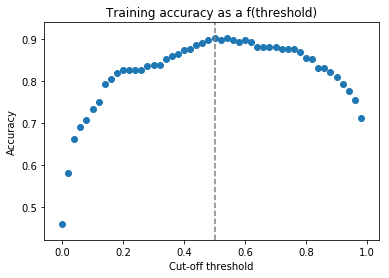

In [11]:
# generate a range of thresholds from 0 to 1.
h=.02
x_min=0.0
x_max=1.0

plt.figure()
thresh=np.arange(x_min, x_max, h)
accs = explore_thresholds(logreg, X_clf, y_train, thresh)
plt.rcParams['figure.figsize'] = [9.5, 6]
plt.scatter(thresh, accs)
plt.xlabel('Cut-off threshold')
plt.ylabel('Accuracy')
plt.title('Training accuracy as a f(threshold)')
plt.axvline(x=0.5,color='gray', linestyle='--') 
plt.show()

The dashed line denotes the threshold value used "by default". 
<div class="alert alert-info">

**Question 9:** Based on this results, would you rather use your "personalized" threshold to predict future samples? If yes, which value? <u>justify your answer</u>. 

</div>

**Your answer here:**
___
We would rather not change the default threshold since **the accuracy on the training set is already maximum with the default threshold.** 

However since accuracy might not be the best metric considering the goal we want to reach, we could investigate the impact of the threshold on other metrics such as precision or recall. 

If our goal is to minimize the False Negative (Diseased diagnosed as Healthy), we should better use recall instead of accuracy.
___

In [12]:
#If you chose a specific threshold value to use as cut-off replace 0.5 with your chosen value (or with any value)
custom_t = 0.5

Finally, let us use the model(s) to predict the unseen data:

In [13]:
print('******************  Testing accuracy (identifying diseased condition) *********************')
print('ACC: ', predict_and_test(logreg,X_clf_test, y_test))
print('*******************************************************************************************')

#If you chose a specific threshold value to use as cut-off this will be displayed
if custom_t != 0.5:
    print('*********  Testing Acc with custom cut-off (identifying diseased condition)***********')
    print('ACC: ',explore_thresholds(logreg, X_clf_test, y_test, [custom_t])[0])
    print('*******************************************************************************************')


******************  Testing accuracy (identifying diseased condition) *********************
ACC:  0.7833333333333333
*******************************************************************************************


# Multinomial classification
Now, we want to know the precise diagnosis of a subject and not just to identify their overall condition (healthy or sick). For that purpose we will use a multinomial classifier. 

<div class="alert alert-info">

**Exercise 7:** Code all the necessary steps to train a multinomial logistic regression model and then predict the outputs of unseen data using it. 

</div>

In [24]:
# Import classifier from our beloved lib <3
from sklearn.linear_model import LogisticRegression

# Multinomial classification, the target is diagnosis now
train = pd.read_csv('data/train_heart.csv')
test = pd.read_csv('data/test_heart.csv')

X_train = train.drop(['condition','diagnosis'], axis=1)
y_train = train['diagnosis']

X_test = test.drop(['condition','diagnosis'], axis=1)
y_test = test['diagnosis']

# Prepare data (select features, 1-K encoding, standardisation)
X_clf_train = prepare_data(X_train)
X_clf_test = prepare_data(X_test)


# Create model and train (let's try another solver, here lbfgs handle multinomial loss)

# print(balance_class, y_train.value_counts())

multinomial_clf = LogisticRegression(solver='lbfgs',
                                     multi_class='multinomial') #multinomial loss (!= 1 against all)
multinomial_clf = utils.fit_logreg(X_clf_train, y_train)


Assume there is a dummy model that outputs healthy (diagnosis=0) for every single input. The code below implements such a model. 

In [18]:
class DummyModel:
    def __init__(self):
        pass
    
    def predict(self, X):
        '''
        Returns a zero (no disease) no matter the input
        '''
        return pd.Series(np.zeros(len(X)))
    
dummy_model = DummyModel()

<div class="alert alert-info">

**Exercise 8:** Compare the accuracy of your model and the dummy model on the testing data.
</div>    

In [25]:
# Compute acc
acc_dummy = predict_and_test(dummy_model, X_clf_test, y_test)
acc_test = predict_and_test(multinomial_clf, X_clf_test, y_test)

# print('test data:\n', y_test.value_counts())
# print('\ntraining data:\n', y_train.value_counts())

print('\n******************  Testing accuracy *********************')
print('ACC multinomial: ', acc_test)
print('ACC dummy: ', acc_dummy)
print('**********************************************************')


******************  Testing accuracy *********************
ACC multinomial:  0.5333333333333333
ACC dummy:  0.5333333333333333
**********************************************************


<div class="alert alert-info">
    
**Question 10:** Which one is better? What can you say about your model based on these results? 

</div>

**Your answer here:**
___
Here the multinomial classifier gave slighlty better result than the dummy classifier on the accuracy metrics.

First, the classes are heavily **unbalanced** in both the test and training set. 

Second, we evaluate models based on a **single metric (accuracy)** which is perhaps not the most relevant one according to our goal.
___

# Part 3: Comparing to a different family of methods

In this last part of the lab, we are going to compare logistic regression to a different type of methods that we have not covered in the course and, more specifically, the k nearest neighbors algorithm (kNN).

kNN is considered a non-parametric method given that it makes few assumptions about the form of the data distribution. This approach is *memory-based* as it requires no model to be fit. Nearest-neighbor methods use the observations from the training set closest in input space to $x$ to form $\hat{y}$. It is based on the assumption that if a sample's features are similar to the ones of points of one particular class then it belongs to that class. These points are known as nearest neighbors.

The specific case where $k=1$ is denoted the nearest neighbor algorithm. Here $\hat{y}$ is assigned the value $y_{l}$ of the closest point $x_{l}$ to $x$ in the training data. This corresponds to a *Voronoi tessellation* of the training data. 

#### Algorithm
Given a query point $\mathbf{x}_0$ and a training set $T=(\mathbf{x}_i, y_i)$, $i = 1,..., N$:<br>
1- Compute the distance $d(\mathbf{x}_0, \mathbf{x}_i)$ between $\mathbf{x}_0$ and all $\mathbf{x}_i \in T$.<br>
2- Sort all $ \mathbf{x}_i$ using $d(\mathbf{x}_0, \mathbf{x}_i)$ as sorting criterion.<br>
3- Select the first $K$ points. This points are denoted the k-neighborhood of $\mathbf{x}_0$, $N_k(\mathbf{x}_0)$.<br>
4- Assign $\hat{y}(\mathbf{x}_0$) based on majority voting:
\begin{equation}
\hat{y}(\mathbf{x}_0) = \arg\max_{y} \sum_{\mathbf{x}_i \in N_k} I(y = y_i)
\end{equation}

An illustration of the algorithm is shown below:
<center>
<img src="data/knn.png" width="200" />

The test sample (green dot) should be classified either to blue squares or to red triangles. If k = 3 (solid line circle) it is assigned to the red triangles because there are 2 triangles and only 1 square inside the inner circle. If k = 5 (dashed line circle) it is assigned to the blue squares (3 squares vs. 2 triangles inside the outer circle). Source: <a href="https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm">Wikipedia</a>.    
</center>

<div class="alert alert-info">

**Exercise 9:** Your first task is to implement the K nearest neighbor algorithm by completing the code below. Use the Euclidean distance to measure the distance between two points.
    
</div>

In [4]:
from scipy.spatial import distance


class KNN:
    def __init__(self, K):
        self.X = []
        self.y = []
        self.k = K
        
    def train(self, X, y): 
        self.X = X
        self.y = y
       
    def predict(self, X_new):
        distances = []
        
        # Compute distance between X_new et every points in memory: self.X
        for k in range(len(self.X)):
            dst = distance.euclidean(self.X[k], X_new)
            label = self.y[k]
            distances.append((dst, label)) # store distance and label together
            
        distances.sort(key=lambda x:x[0]) # sort by distance
        distances = distances[:self.k] # select K nearest neighbour
        distances = [k[1] for k in distances] # strip the label only
    
        prediction = max(distances, key=distances.count) # get the label that appears the most
        
        return prediction
            

#### Testing your implementation
To evaluate the algorithm we are going to use synthetic data coming from a Gaussian mixture model composed of 3 multivariate Gaussian distributions with different means and common covariance. Data is obtained by calling the function <code>gaussians()</code> from the <code>utils.py</code> file.

<div class="alert alert-info">

**Exercise 10:** Complete the code below in order to build a model using your K-NN implementation and then predict for unseen data. The obtained results will be compared with those obtained using scikit-learn implementation. 
    
Test for different values of K. Comment on the obtained results. You can add images to your notebook using ```<img src="path/to/image.png" />```
    
</div>

In [6]:
X, y = utils.gaussians()
print(X.shape)
print(y.shape)

(150, 2)
(150,)


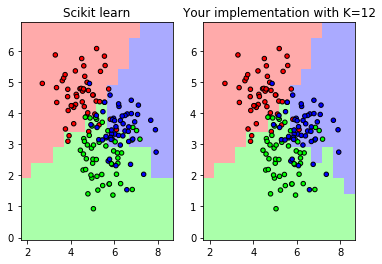

In [7]:
from sklearn import neighbors, datasets

h=0.5
iris = datasets.load_iris()

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

X_test = np.c_[xx.ravel(), yy.ravel()] #This is the testing data

K=int(np.sqrt(len(X)))
knn = KNN(K)
#----------------------------- Your code here -------------------------------------

knn.train(X, y)
y_test = []
for x_test in X_test:
    y_test.append(knn.predict(x_test))
y_test = np.array(y_test)

#--------------------------- end of your code --------------------------------------

# Put the result into a color plot
y_test = y_test.reshape(xx.shape)

#Scikit-learn implementation
clf = neighbors.KNeighborsClassifier(K, algorithm='kd_tree') #, weights=weights)
clf.fit(X, y)
Z = clf.predict(X_test)
# Put the result into a color plot
Z = Z.reshape(xx.shape)    

#Compare results
utils.comparing_plots(xx,yy, X, y, Z, y_test, "Scikit learn", "Your implementation with K=" + str(K))


___
- With K close to 1, the model is highly **sensitive to noise**. (overfit)
- With K = N, the model always predict the majority class. (underfit)
- As a rule of thumb K ~ sqrt(N) is generally a good starting point.
___

##### **Knn K=1**
<img src="KNN/K=1.png" />

##### **Knn K=sqrt(N)=12**
<img src="KNN/K=12.png" />

##### **Knn K=50**
<img src="KNN/K=50.png" />

##### **Knn K=N=150**
<img src="KNN/K=150.png" />


#### Comparing KNN and Logistic regression
Finally, we will compare the behaviour of a linear model, such as logistic regression, with KNN. 

<div class="alert alert-info">

**Exercise 10:** Using code from Part 2, train a logistic regression model with the data from the iris dataset and then predict the unseen samples <code>X_test</code>. Store your results in a variable called <code>logistic_results</code>. This will be used to plot the regions defined by the decision functions of the logistic regressor.
    
Train your KNN classifier, with a K of your choice and then predict the unseen samples. Store the results in a variable called <code>knn_results</code>.
   
Have a look at the plots:

    1) What can you say of the behaviour of the two models? 
    2) Play around with your K. What changes do you see? Which value of K would you recommend to get decision boundaries similar to those of logistic regression?
    3) Based on your results, when would you recommend to use KNN? When a linear model?
</div>

/usr/local/lib/python3.5/dist-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.5/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


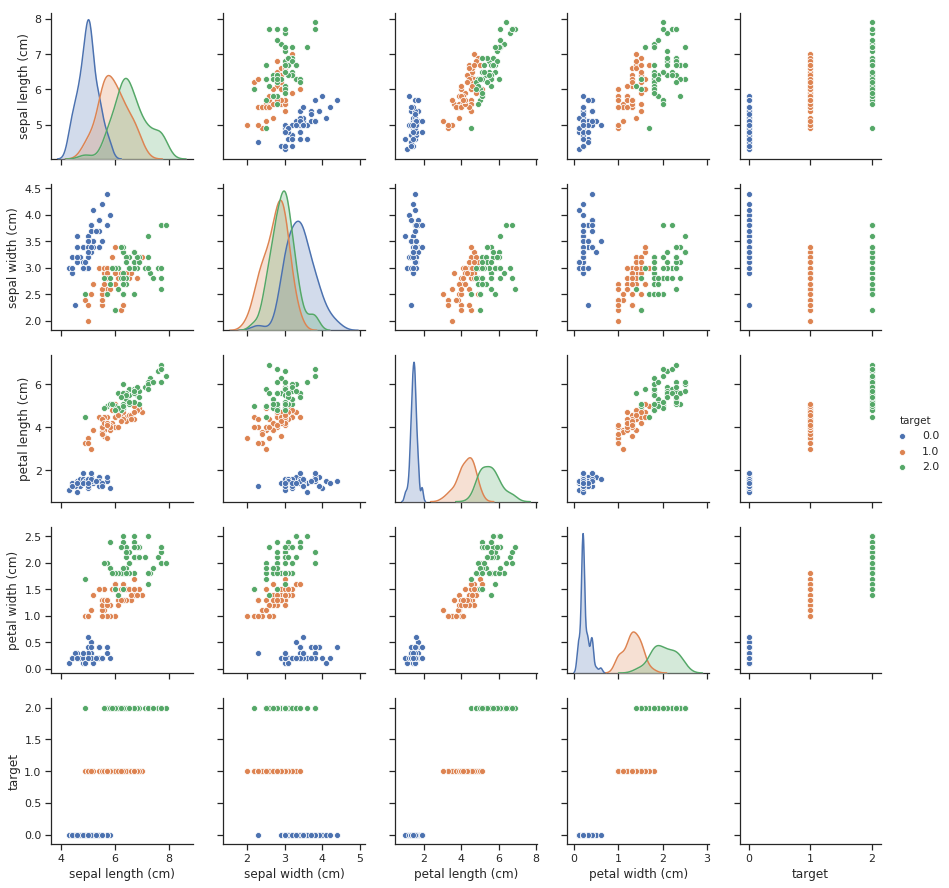

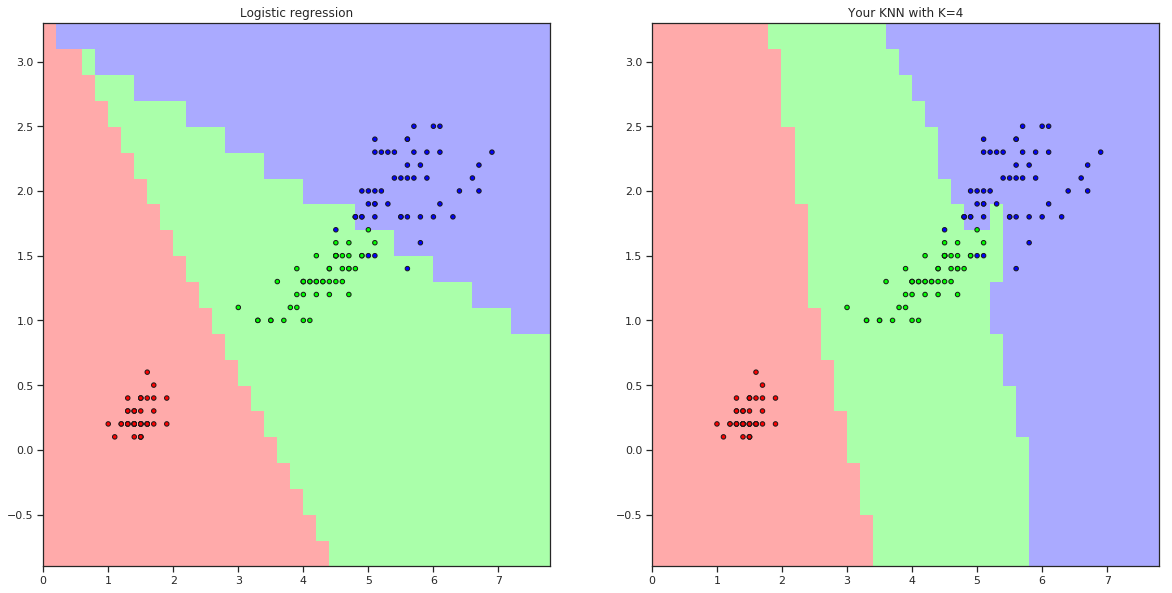

In [36]:
from sklearn.linear_model import LogisticRegression
import seaborn as sns

# Prepare data
iris_df = pd.DataFrame(data= np.c_[iris['data'], iris['target']], columns= iris['feature_names'] + ['target'])
sns.pairplot(iris_df, hue="target")

# Let's limit the number of feature.
# We have to select 2 features to train our model
# among: petal length, petal width, sepal length, sepal width.
#
# Petal width and petal length are linearly separable and have 
# just slightly overlapping distributions, so they are our best features.
X_iris_train = iris_df[['petal length (cm)', 'petal width (cm)']]
y_iris_train = iris_df['target']  


# Meshgrid
h=0.2
X=np.array(X_iris_train)
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
X_test = np.c_[xx.ravel(), yy.ravel()] #This is the testing data



# 1) Your logistic regression code here:
multinomial_iris_clf = LogisticRegression(C=1e20, solver='lbfgs', max_iter=400)
multinomial_iris_clf.fit(X_iris_train, y_iris_train)

logistic_results = multinomial_iris_clf.predict(X_test)
logistic_results = logistic_results.reshape(xx.shape)  




# 2) Your KNN code here
K = int(np.sqrt(len(X_iris_train)))
knn_iris = KNN(K)
knn_iris.train(np.array(X_iris_train), y_iris_train)

knn_results = []
for x_test in X_test:
    knn_results.append(knn_iris.predict(x_test))

knn_results = np.array(knn_results)
knn_results = knn_results.reshape(xx.shape)




# Compare results
utils.comparing_plots(xx,yy, np.array(X_iris_train), np.array(y_iris_train), logistic_results, knn_results, "Logistic regression", "Your KNN with K=" + str(K))


**Your answer here:**
___
- First, it is important to choose 2 features that are linearly separable. For that the best is too choose 2 features whose species' distributions are not overlapping with other: $petal\_width$ and $petal\_length$ present distributions that are just slightly overlapping. On the other hand $sepal\_width$ and $sepal\_length$ present distributions that are overlapping so we would not recommand $sepal\_width$ and $sepal\_length$ as features for our model. Instead we recommand $petal\_width$ and $petal\_length$.

- 1) The 2 models behave correctly. They are both able to classify the data.

- 2) Knn classifier works well for K=int(sqrt(150))=12. The model is not too sensible to noise that way.

- 3) Knn works well when the classes **are not** linearly separable, on the other hand logistic regression works well when the data **are** linearly separable. Then Knn works well on classification with lots of classes, but the computation is expensive, where logistic regression works well on classification with few classes.